In [2]:
!pip install torchsummary

In [3]:
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms 
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import matplotlib.pyplot as plt
import os
from PIL import Image
from glob import glob
import cv2
import pandas as pd
import numpy as np
from skimage.io import imread
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [4]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # transforms.Normalize(data_mean, data_std)
])

In [5]:
train_directory = '/kaggle/input/architectural-heritage-elements-image64-dataset/train'
test_directory = '/kaggle/input/architectural-heritage-elements-image64-dataset/test'

bs = 32

num_classes = 10

data = {
    'train': datasets.ImageFolder(root=train_directory, transform = transform),
    'test': datasets.ImageFolder(root=test_directory, transform= transform),
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

train_data_size = len(data['train'])
test_data_size = len(data['test'])

train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

{0: 'altar', 1: 'apse', 2: 'bell_tower', 3: 'column', 4: 'dome(inner)', 5: 'dome(outer)', 6: 'flying_buttress', 7: 'gargoyle', 8: 'stained_glass', 9: 'vault'}


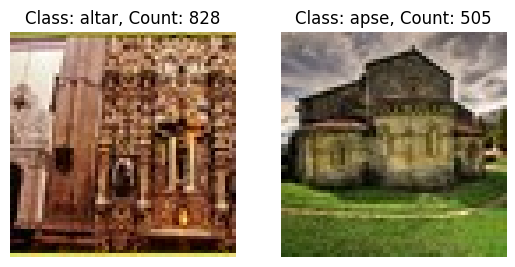

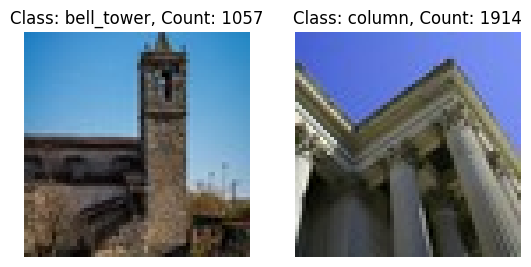

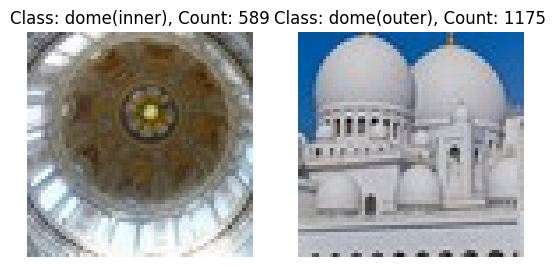

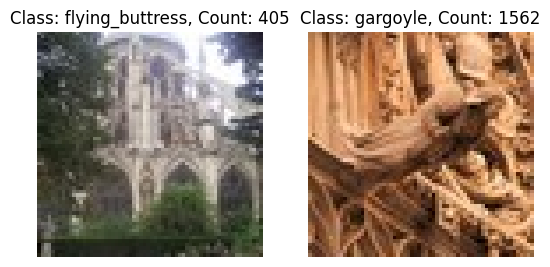

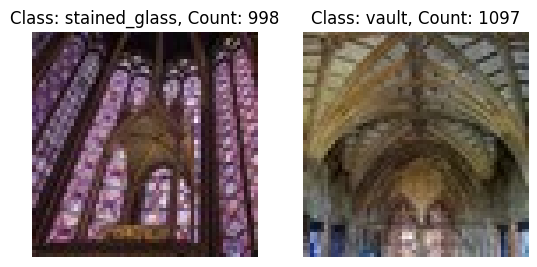

Class: altar, Images: 828
Class: apse, Images: 505
Class: bell_tower, Images: 1057
Class: column, Images: 1914
Class: dome(inner), Images: 589
Class: dome(outer), Images: 1175
Class: flying_buttress, Images: 405
Class: gargoyle, Images: 1562
Class: stained_glass, Images: 998
Class: vault, Images: 1097


In [6]:
train_directory = '/kaggle/input/architectural-heritage-elements-image64-dataset/train'
class_folders = sorted(os.listdir(train_directory))
class_image_counts = {}
for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(train_directory, class_folder)
    images = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
    class_image_counts[class_folder] = len(images)
    if len(images) > 0:
        image_path = os.path.join(class_path, images[0]) 
        image = Image.open(image_path)
        if i % 2 == 0:
            fig, axes = plt.subplots(1, 2)
        ax = axes[i % 2] if len(class_folders) > 1 else axes 
        ax.imshow(image)
        ax.set_title(f"Class: {class_folder}, Count: {len(images)}")
        ax.axis('off')
    
        if i % 2 == 1 or i == len(class_folders) - 1:
            plt.show()


for class_folder, count in class_image_counts.items():
    print(f"Class: {class_folder}, Images: {count}")


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(12, 12, kernel_size=(3, 3), stride=2, padding=1)

        
        self.cnn_layers = nn.Sequential(
            self.conv1,
            nn.ReLU(inplace=True),
            
            self.conv2,
            nn.ReLU(inplace=True),
            
            self.conv3,
            nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2),
        )
        
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9408, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x, conv_feature = 0):
        x = self.cnn_layers(x)
        if conv_feature == 1:
            return x
        x = self.linear_layers(x)
        return x
    
    def cnn_vision(self, x):
        feature_maps1 = self.conv1(x[0].to(device))
        self.plot_conv(3, 4, feature_maps1, 1)
        feature_maps2 = self.conv2(nn.functional.relu(feature_maps1))
        self.plot_conv(3, 4, feature_maps2, 2)
        feature_maps3 = self.conv2(nn.functional.relu(feature_maps2))
        self.plot_conv(3, 4, feature_maps3, 3)
        
    def plot_conv(self, h, w, feature_maps, layer):
        ix = 1
        for _ in range(h):
            for _ in range(w):
                ax = plt.subplot(h, w, ix)
                ax.set_xticks([])
                ax.set_yticks([])

                plt.imshow(feature_maps[ix-1, :, :].cpu().detach().numpy(), cmap='viridis')
                plt.title("conv layer {}".format(layer))
                ix += 1
        plt.show()
        



In [36]:
model = Net()

optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (cnn_layers): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9408, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


Epoch 1/20: 100%|██████████| 317/317 [00:36<00:00,  8.67it/s]


Epoch [1/20], Loss: 1.5893, Accuracy: 0.4132


Epoch 2/20: 100%|██████████| 317/317 [00:27<00:00, 11.52it/s]


Epoch [2/20], Loss: 1.1257, Accuracy: 0.6016


Epoch 3/20: 100%|██████████| 317/317 [00:28<00:00, 11.22it/s]


Epoch [3/20], Loss: 0.8820, Accuracy: 0.6949


Epoch 4/20: 100%|██████████| 317/317 [00:27<00:00, 11.48it/s]


Epoch [4/20], Loss: 0.7107, Accuracy: 0.7549


Epoch 5/20: 100%|██████████| 317/317 [00:27<00:00, 11.49it/s]


Epoch [5/20], Loss: 0.5875, Accuracy: 0.8008


Epoch 6/20: 100%|██████████| 317/317 [00:27<00:00, 11.42it/s]


Epoch [6/20], Loss: 0.4647, Accuracy: 0.8463


Epoch 7/20: 100%|██████████| 317/317 [00:27<00:00, 11.54it/s]


Epoch [7/20], Loss: 0.3467, Accuracy: 0.8821


Epoch 8/20: 100%|██████████| 317/317 [00:27<00:00, 11.33it/s]


Epoch [8/20], Loss: 0.2725, Accuracy: 0.9091


Epoch 9/20: 100%|██████████| 317/317 [00:28<00:00, 11.25it/s]


Epoch [9/20], Loss: 0.2171, Accuracy: 0.9278


Epoch 10/20: 100%|██████████| 317/317 [00:27<00:00, 11.54it/s]


Epoch [10/20], Loss: 0.1680, Accuracy: 0.9451


Epoch 11/20: 100%|██████████| 317/317 [00:27<00:00, 11.50it/s]


Epoch [11/20], Loss: 0.1465, Accuracy: 0.9516


Epoch 12/20: 100%|██████████| 317/317 [00:27<00:00, 11.64it/s]


Epoch [12/20], Loss: 0.1377, Accuracy: 0.9567


Epoch 13/20: 100%|██████████| 317/317 [00:27<00:00, 11.59it/s]


Epoch [13/20], Loss: 0.1024, Accuracy: 0.9666


Epoch 14/20: 100%|██████████| 317/317 [00:27<00:00, 11.58it/s]


Epoch [14/20], Loss: 0.1229, Accuracy: 0.9605


Epoch 15/20: 100%|██████████| 317/317 [00:27<00:00, 11.61it/s]


Epoch [15/20], Loss: 0.0960, Accuracy: 0.9686


Epoch 16/20: 100%|██████████| 317/317 [00:27<00:00, 11.41it/s]


Epoch [16/20], Loss: 0.0868, Accuracy: 0.9715


Epoch 17/20: 100%|██████████| 317/317 [00:27<00:00, 11.45it/s]


Epoch [17/20], Loss: 0.0658, Accuracy: 0.9784


Epoch 18/20: 100%|██████████| 317/317 [00:28<00:00, 11.30it/s]


Epoch [18/20], Loss: 0.0749, Accuracy: 0.9757


Epoch 19/20: 100%|██████████| 317/317 [00:27<00:00, 11.63it/s]


Epoch [19/20], Loss: 0.0779, Accuracy: 0.9744


Epoch 20/20: 100%|██████████| 317/317 [00:28<00:00, 11.27it/s]


Epoch [20/20], Loss: 0.0771, Accuracy: 0.9746


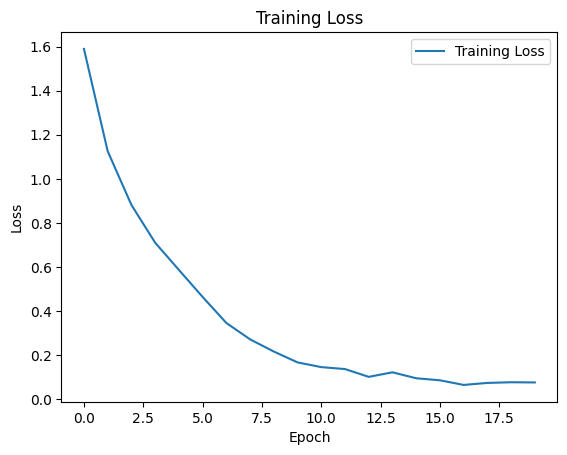

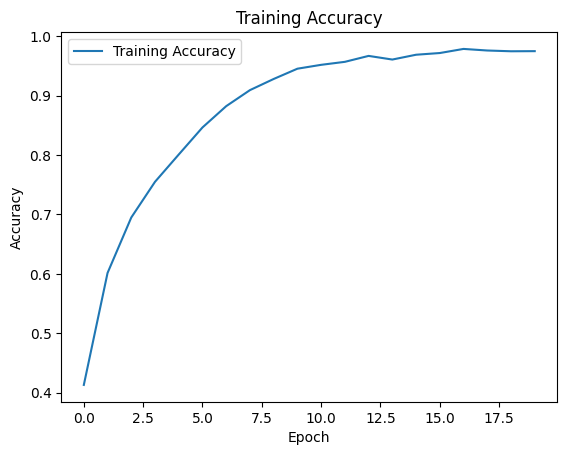

Training finished


In [37]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []

for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    
    for images, labels in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{20}"):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / train_data_size
    epoch_accuracy = correct_predictions / train_data_size

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{20}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

print('Training finished')


Epoch 1/20: 100%|██████████| 317/317 [00:59<00:00,  5.33it/s]


Epoch [1/20], Loss: 1.5063, Accuracy: 0.4405


Epoch 2/20: 100%|██████████| 317/317 [00:27<00:00, 11.50it/s]


Epoch [2/20], Loss: 1.0419, Accuracy: 0.6386


Epoch 3/20: 100%|██████████| 317/317 [00:27<00:00, 11.64it/s]


Epoch [3/20], Loss: 0.8658, Accuracy: 0.6991


Epoch 4/20: 100%|██████████| 317/317 [00:27<00:00, 11.42it/s]


Epoch [4/20], Loss: 0.7507, Accuracy: 0.7363


Epoch 5/20: 100%|██████████| 317/317 [00:27<00:00, 11.44it/s]


Epoch [5/20], Loss: 0.6368, Accuracy: 0.7758


Epoch 6/20: 100%|██████████| 317/317 [00:26<00:00, 11.79it/s]


Epoch [6/20], Loss: 0.5458, Accuracy: 0.8097


Epoch 7/20: 100%|██████████| 317/317 [00:27<00:00, 11.67it/s]


Epoch [7/20], Loss: 0.4675, Accuracy: 0.8386


Epoch 8/20: 100%|██████████| 317/317 [00:28<00:00, 11.31it/s]


Epoch [8/20], Loss: 0.3959, Accuracy: 0.8649


Epoch 9/20: 100%|██████████| 317/317 [00:26<00:00, 11.88it/s]


Epoch [9/20], Loss: 0.3504, Accuracy: 0.8811


Epoch 10/20: 100%|██████████| 317/317 [00:26<00:00, 11.84it/s]


Epoch [10/20], Loss: 0.3084, Accuracy: 0.8975


Epoch 11/20: 100%|██████████| 317/317 [00:26<00:00, 11.83it/s]


Epoch [11/20], Loss: 0.2515, Accuracy: 0.9162


Epoch 12/20: 100%|██████████| 317/317 [00:27<00:00, 11.60it/s]


Epoch [12/20], Loss: 0.2256, Accuracy: 0.9258


Epoch 13/20: 100%|██████████| 317/317 [00:27<00:00, 11.73it/s]


Epoch [13/20], Loss: 0.1949, Accuracy: 0.9337


Epoch 14/20: 100%|██████████| 317/317 [00:27<00:00, 11.67it/s]


Epoch [14/20], Loss: 0.1830, Accuracy: 0.9387


Epoch 15/20: 100%|██████████| 317/317 [00:29<00:00, 10.75it/s]


Epoch [15/20], Loss: 0.1633, Accuracy: 0.9435


Epoch 16/20: 100%|██████████| 317/317 [00:28<00:00, 11.13it/s]


Epoch [16/20], Loss: 0.1380, Accuracy: 0.9528


Epoch 17/20: 100%|██████████| 317/317 [00:27<00:00, 11.54it/s]


Epoch [17/20], Loss: 0.1464, Accuracy: 0.9523


Epoch 18/20: 100%|██████████| 317/317 [00:26<00:00, 11.82it/s]


Epoch [18/20], Loss: 0.1130, Accuracy: 0.9616


Epoch 19/20: 100%|██████████| 317/317 [00:27<00:00, 11.57it/s]


Epoch [19/20], Loss: 0.1041, Accuracy: 0.9637


Epoch 20/20: 100%|██████████| 317/317 [00:27<00:00, 11.68it/s]


Epoch [20/20], Loss: 0.1250, Accuracy: 0.9594


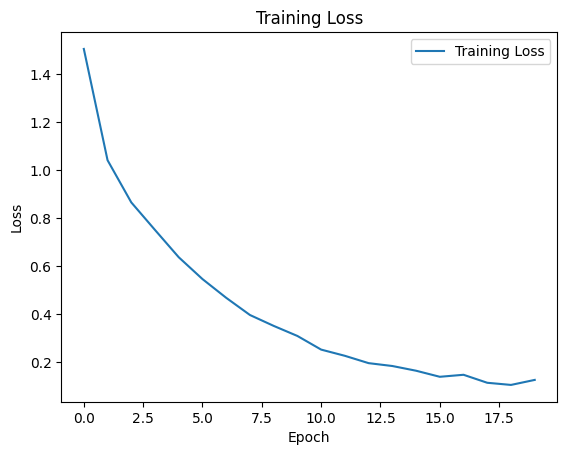

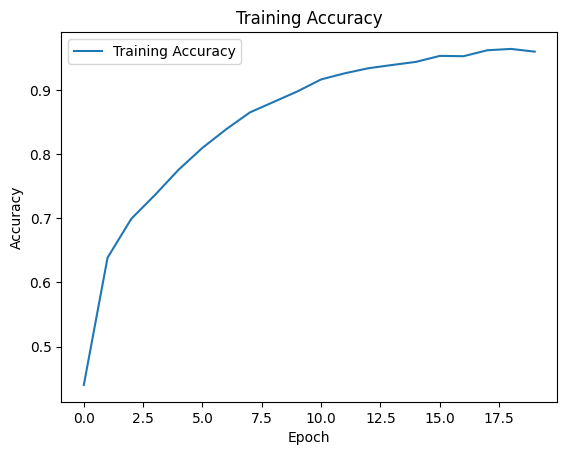

Training finished


In [12]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []

for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    
    for images, labels in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{20}"):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / train_data_size
    epoch_accuracy = correct_predictions / train_data_size

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{20}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

print('Training finished')


In [70]:
torch.save(model.state_dict(), 'model_weights.pth')

In [38]:
def test(model, test_data_loader):
    model.eval() 
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in test_data_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples

    return accuracy

accuracy = test(model, test_data_loader)
print(f'Accuracy on test set: {accuracy:.2%}')

Accuracy on test set: 64.96%


In [13]:
def test(model, test_data_loader):
    model.eval() 
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in test_data_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples

    return accuracy

accuracy = test(model, test_data_loader)
print(f'Accuracy on test set: {accuracy:.2%}')

Accuracy on test set: 71.44%


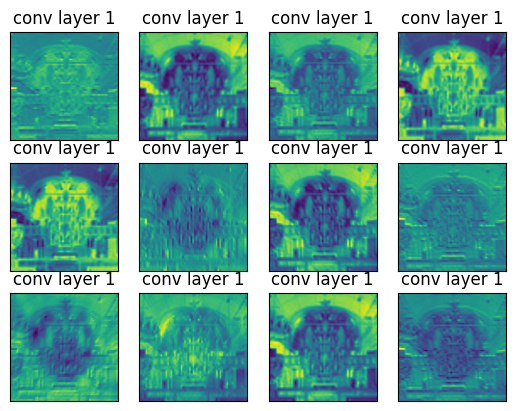

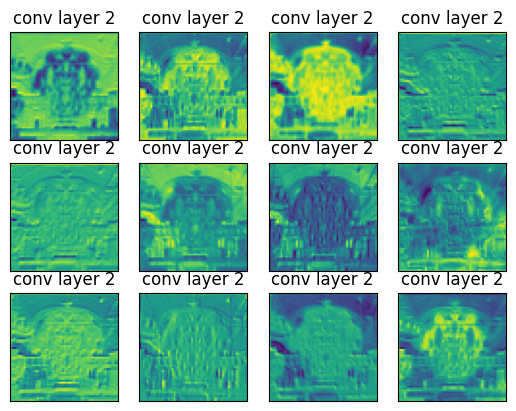

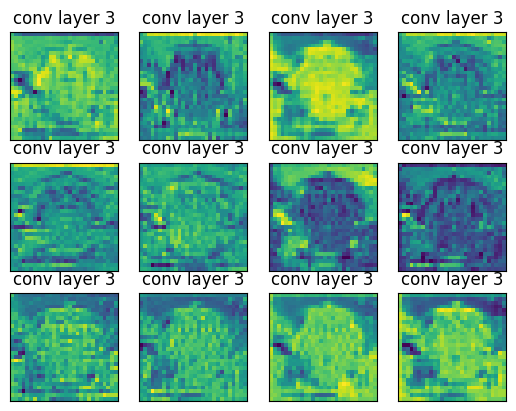

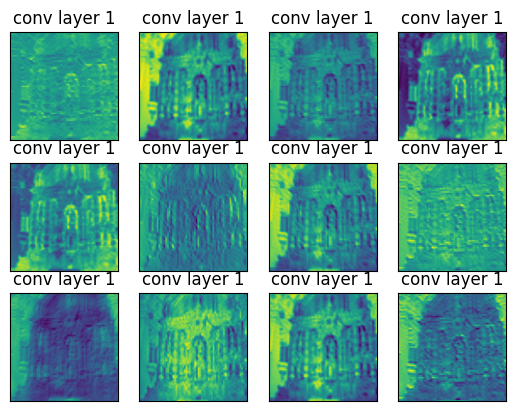

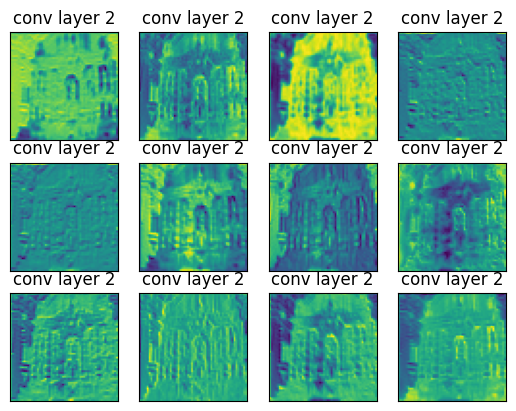

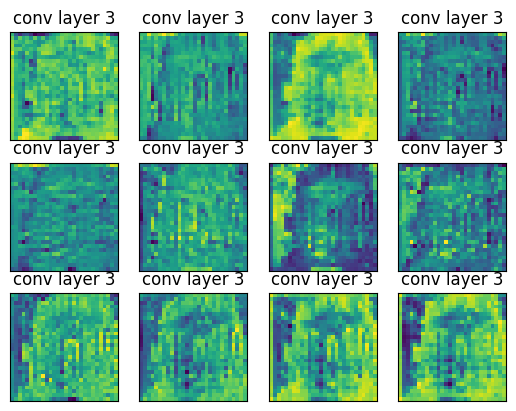

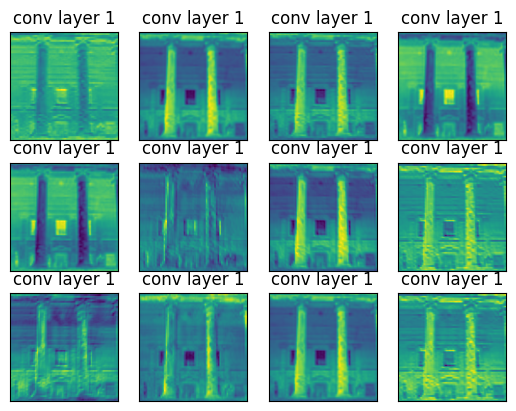

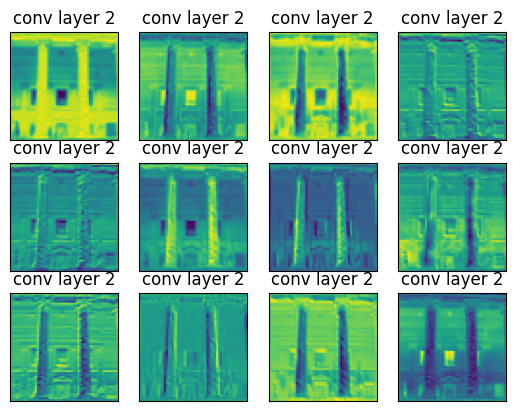

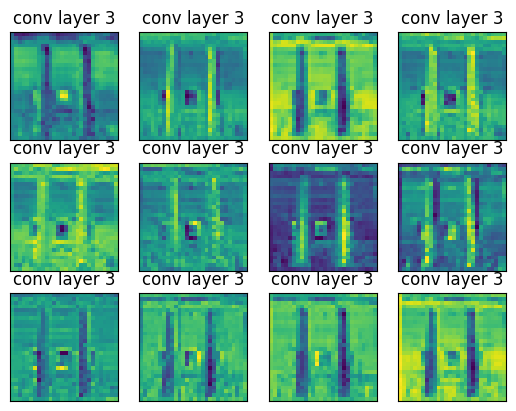

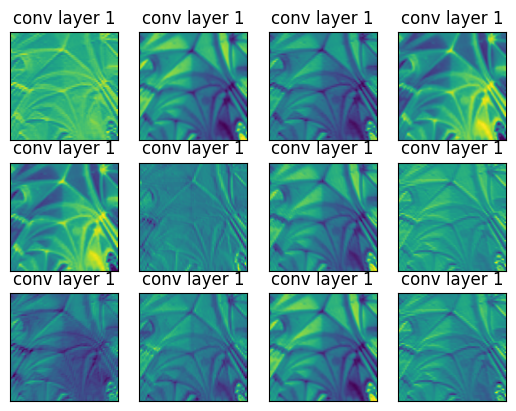

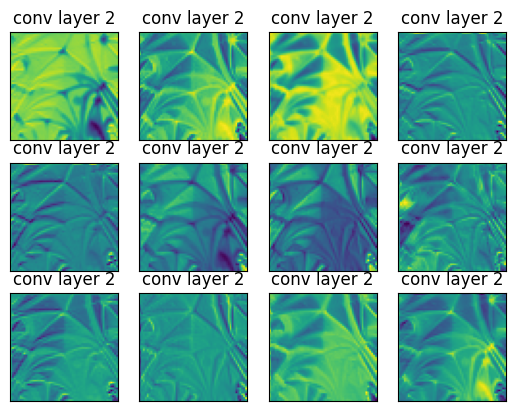

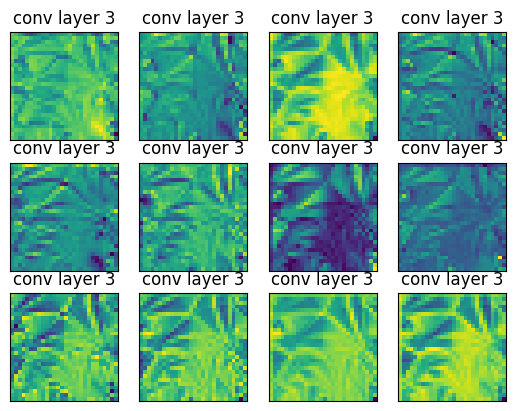

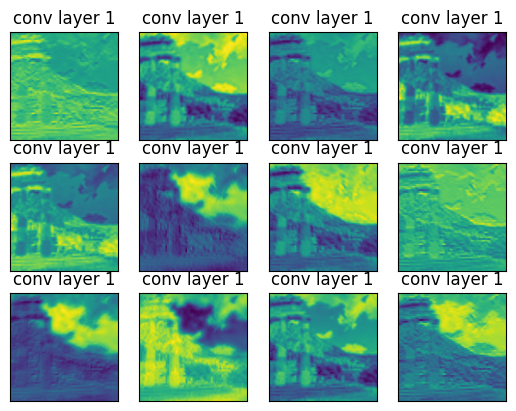

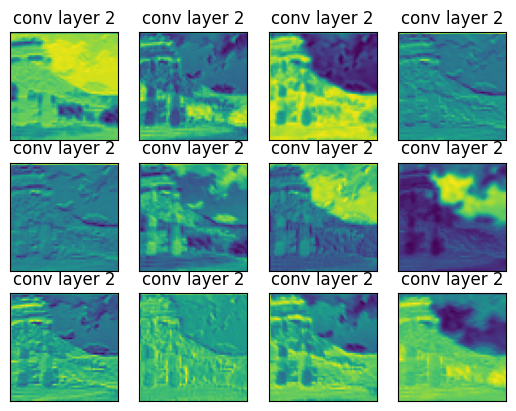

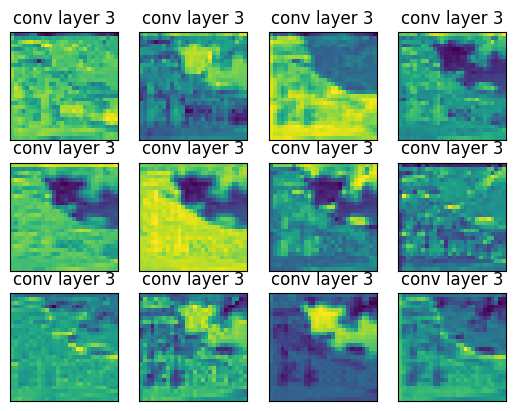

In [14]:
count = 0
with torch.no_grad():
    for images, labels in test_data_loader:
        count += 1
        images = images.cuda()
        model.eval()
        model.cnn_vision(images)
        if count == 5:
            break

In [39]:
from math import floor, ceil
def transposed_conv(x, W, padding="valid", strides=(2, 2)):
    row_num = (x.shape[0] - 1) * strides[0] + W.shape[0]
    col_num = (x.shape[1] - 1) * strides[1] + W.shape[1]
    output = np.zeros([row_num, col_num])
   
    for i in range(0, x.shape[0]):
        i_2 = i * strides[0]
        for j in range(0, x.shape[1]):
            j_2 = j * strides[1]
            for k_row in range(W.shape[0]):
                for k_col in range(W.shape[1]):
                    output[i_2+k_row, j_2+k_col] += W[k_row, k_col] * x[i, j]
   
    if padding == "default":
        p_left = floor((W.shape[0] - strides[0]) / 2)
        p_right = W.shape[0] - strides[0] - p_left
        p_top = floor((W.shape[1] - strides[1]) / 2)
        p_bottom = W.shape[1] - strides[1] - p_left
    else:
        p_left = 0
        p_right = 0
        p_top = 0
        p_bottom = 0

    output_padded = output[p_left:output.shape[0] - p_right, p_top:output.shape[0] - p_bottom]
    return(np.array(output_padded))

In [50]:
test2 = DataLoader(data['test'], batch_size=1, shuffle=True)

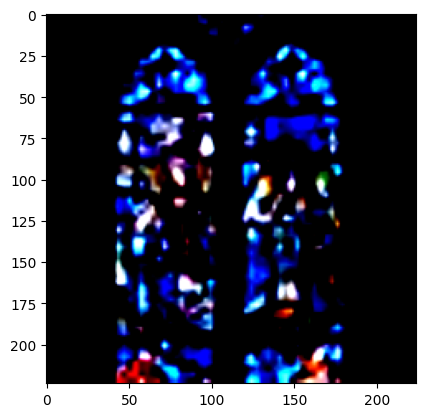

torch.Size([28, 28])


In [51]:
count = 0
with torch.no_grad():
    for images, labels in test2:
        count += 1
        images = images.cuda()
        first_image = images[0].cpu().numpy()
        first_image = np.transpose(first_image, (1, 2, 0))

        plt.imshow(first_image)
        plt.show()
        model.eval()
        x = model(images, 1)[0][0]
        print(x.shape)
        w = model.conv3.weight[0][0].T
        out3 = transposed_conv(x, w, padding = 'default', strides = (2, 2))
        if count == 1:
            break


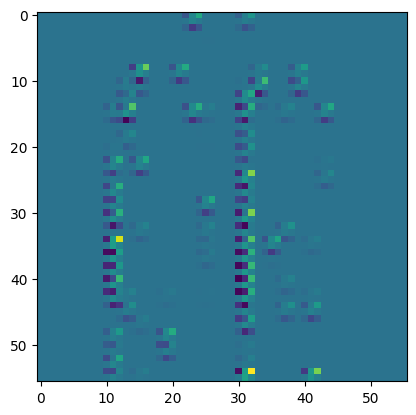

In [52]:
plt.imshow(out3)

In [72]:
import torch.nn as nn

class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(12, 12, kernel_size=(3, 3), stride=2, padding=1)

        
        self.cnn_layers = nn.Sequential(
            self.conv1,
            nn.ReLU(inplace=True),
            
            self.conv2,
            nn.ReLU(inplace=True),

            
            self.conv3,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2352, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x


In [73]:
model = NewNet()
weight_decay = 0.001 
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

NewNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (cnn_layers): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2352, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=512, out_features=256, bias=T

Epoch 1/10: 100%|██████████| 317/317 [00:27<00:00, 11.63it/s]


Epoch [1/10], Loss: 1.3463, Accuracy: 0.5192


Epoch 2/10: 100%|██████████| 317/317 [00:27<00:00, 11.36it/s]


Epoch [2/10], Loss: 1.0262, Accuracy: 0.6447


Epoch 3/10: 100%|██████████| 317/317 [00:27<00:00, 11.66it/s]


Epoch [3/10], Loss: 0.8680, Accuracy: 0.6972


Epoch 4/10: 100%|██████████| 317/317 [00:27<00:00, 11.67it/s]


Epoch [4/10], Loss: 0.8122, Accuracy: 0.7241


Epoch 5/10: 100%|██████████| 317/317 [00:26<00:00, 11.81it/s]


Epoch [5/10], Loss: 0.7475, Accuracy: 0.7434


Epoch 6/10: 100%|██████████| 317/317 [00:27<00:00, 11.36it/s]


Epoch [6/10], Loss: 0.6884, Accuracy: 0.7643


Epoch 7/10: 100%|██████████| 317/317 [00:27<00:00, 11.64it/s]


Epoch [7/10], Loss: 0.6275, Accuracy: 0.7808


Epoch 8/10: 100%|██████████| 317/317 [00:27<00:00, 11.63it/s]


Epoch [8/10], Loss: 0.6206, Accuracy: 0.7826


Epoch 9/10: 100%|██████████| 317/317 [00:27<00:00, 11.51it/s]


Epoch [9/10], Loss: 0.5730, Accuracy: 0.8007


Epoch 10/10: 100%|██████████| 317/317 [00:27<00:00, 11.65it/s]


Epoch [10/10], Loss: 0.5406, Accuracy: 0.8164


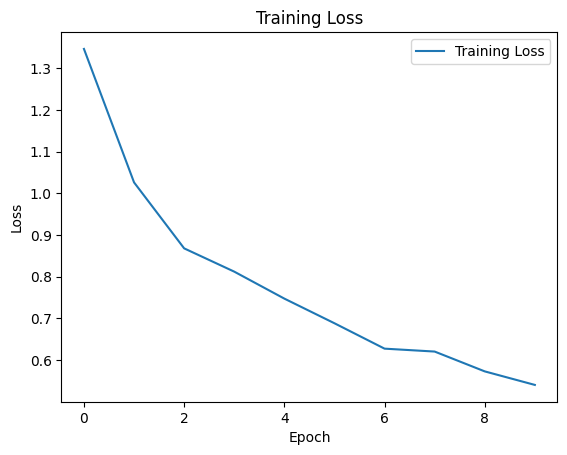

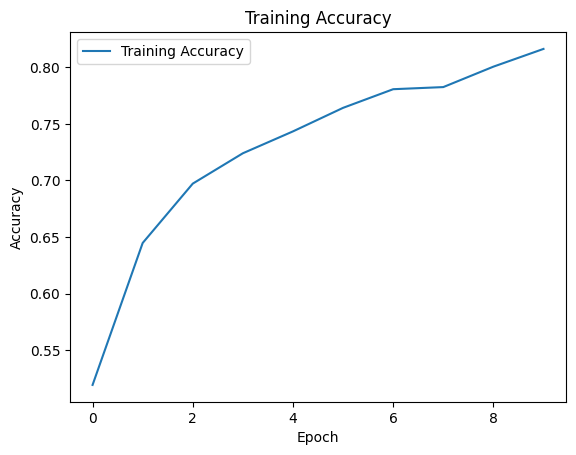

Training finished


In [74]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

train_losses = []
train_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    
    for images, labels in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{10}"):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / train_data_size
    epoch_accuracy = correct_predictions / train_data_size

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{10}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

print('Training finished')


In [75]:
def test(model, test_data_loader):
    model.eval() 
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in test_data_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples

    return accuracy

accuracy = test(model, test_data_loader)
print(f'Accuracy on test set: {accuracy:.2%}')

Accuracy on test set: 67.59%
